In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

1. import data of graphs in

In [21]:
# unpickle graphic data and merge ones only for cats together
def unpickle(file):
    with open(file, 'rb') as f:
        dic = pickle.load(f, encoding='bytes')
    features = dic[b'data'].reshape((len(dic[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = dic[b'labels']
    return (features, labels)

def merge_cat_only(data):
    data_lst = []
    for i in range(len(data[0])):
        if data[1][i] == 3:
            data_lst.append(data[0][i])
    return data_lst

def process(data, file_name):
    unpickled = unpickle(file_name)
    data += merge_cat_only(unpickled)
    return data


In [22]:
data = []
data = process(data, '../data/cifar-10-batches-py/data_batch_1')
data = process(data, '../data/cifar-10-batches-py/data_batch_2')
data = process(data, '../data/cifar-10-batches-py/data_batch_3')
data = process(data, '../data/cifar-10-batches-py/data_batch_4')
data = process(data, '../data/cifar-10-batches-py/data_batch_5')
data = process(data, '../data/cifar-10-batches-py/test_batch')


In [25]:
# shape of the CIFAR-10 data after reformat
np.array(data).shape

(6000, 32, 32, 3)

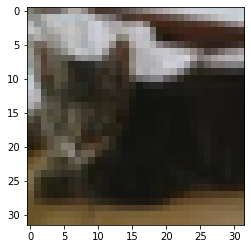

In [45]:
# we will only use cats' graphs, an example:
plt.imshow(data[0])

2. Use pixel information to do k-means clustering

In [51]:
# store data in pixels' format
pixels = np.reshape(data, (6144000, 3))

# do k-means clustering 
kmeans = KMeans(n_clusters=4)
kmeans.fit(pixels)

KMeans(n_clusters=4)

In [52]:
# show cluster centers
kmeans.cluster_centers_

array([[163.3187086 , 151.26074227, 136.77409076],
       [108.28710992,  93.96058495,  79.85542317],
       [ 43.26783083,  36.73813443,  32.31351481],
       [220.13706019, 217.34916432, 212.52691036]])

In [53]:
# assign closest color to each point and generate their corresponding output 
assign_color = kmeans.predict(pixels)
pt_lst = []
Ys = []
for p in range(len(pixels)):
    pt_lst.append([int(assigned) for assigned in kmeans.cluster_centers_[assign_color[p]]])
    if assign_color[p] == 0:
        Ys.append([1, 0, 0, 0])
    elif assign_color[p] == 1:
        Ys.append([0, 1, 0, 0])
    elif assign_color[p] == 2:
        Ys.append([0, 0, 1, 0])
    elif assign_color[p] == 3:
        Ys.append([0, 0, 0, 1])


In [57]:
# get the right format
pt_lst = np.reshape(pt_lst, (6000, 32, 32, 3))
Ys = np.reshape(Ys, (6000, 32, 32, 4))

3. Obtain grayscale 32 × 32 × 1 images from the original 32 × 32 × 3 images as inputs of your network.

In [62]:
from skimage.color import rgb2grey

In [74]:
X = []
pixel_lst = np.reshape(pixels, (6000, 32, 32, 3))
for i in range(len(pixel_lst)):
    X.append(rgb2grey(pixel_lst[i]).tolist())

In [101]:
X = np.reshape(X, (6000, 32, 32, 1))

4. Set up a deep convolutional neural network with two convolution layers and two MLP layers. 

In [102]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

In [103]:
model = Sequential()

In [104]:
model.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same', input_shape = (32,32,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Dense(32, activation='softmax'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_4 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
________________________________________________

In [105]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

5. Randomly split training and test sets:

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, Ys, test_size=0.1, random_state=10)

In [107]:
y_train.shape

(5400, 32, 32, 4)

6. Train with 16 epochs 

In [108]:
network = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=16, verbose=2)

Epoch 1/16
169/169 - 27s - loss: 1.2213 - accuracy: 0.5610 - val_loss: 1.1144 - val_accuracy: 0.7094
Epoch 2/16
169/169 - 27s - loss: 1.0341 - accuracy: 0.7189 - val_loss: 0.9559 - val_accuracy: 0.7325
Epoch 3/16
169/169 - 27s - loss: 0.9022 - accuracy: 0.7359 - val_loss: 0.8439 - val_accuracy: 0.7462
Epoch 4/16
169/169 - 28s - loss: 0.8087 - accuracy: 0.7447 - val_loss: 0.7615 - val_accuracy: 0.7544
Epoch 5/16
169/169 - 28s - loss: 0.7361 - accuracy: 0.7532 - val_loss: 0.6995 - val_accuracy: 0.7596
Epoch 6/16
169/169 - 28s - loss: 0.6827 - accuracy: 0.7578 - val_loss: 0.6521 - val_accuracy: 0.7629
Epoch 7/16
169/169 - 28s - loss: 0.6431 - accuracy: 0.7605 - val_loss: 0.6236 - val_accuracy: 0.7576
Epoch 8/16
169/169 - 28s - loss: 0.6065 - accuracy: 0.7658 - val_loss: 0.5890 - val_accuracy: 0.7640
Epoch 9/16
169/169 - 28s - loss: 0.5792 - accuracy: 0.7685 - val_loss: 0.5608 - val_accuracy: 0.7728
Epoch 10/16
169/169 - 29s - loss: 0.5590 - accuracy: 0.7697 - val_loss: 0.5447 - val_accura

7. Generate test outputs and compare them with test data

In [113]:
# get color information from predictions
prediction = model.predict(X_test)

In [114]:
prediction = prediction.reshape(614400, 4)

In [121]:
output_img = []
for p in range(len(prediction)):
    output_img.append([int(option) for option in kmeans.cluster_centers_[np.argmax(prediction[p])]])
    
# get test information from test set 
y_test_rs = y_test.reshape(614400, 4)
y_test_colors = []
for p in range(len(y_test_rs)):
    y_test_colors.append([int(option) for option in kmeans.cluster_centers_[np.argmax(y_test_rs[p])]])
    
output_img = np.reshape(output_img, (600, 32, 32, 3))
y_test_colors = np.reshape(y_test_colors, (600, 32, 32, 3))

Vitual Comparison: 

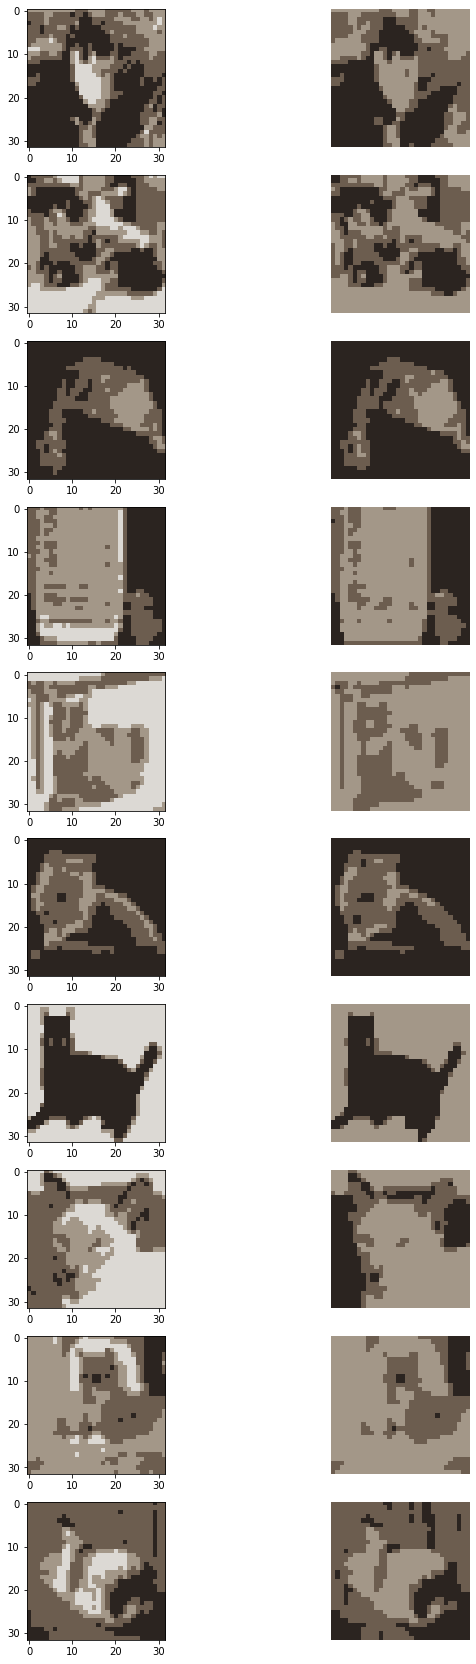

In [122]:
plt.figure(figsize=(10, 30))
subplotcount = 1
for i in range(0,10):
    plt.subplot(10, 2, subplotcount)
    subplotcount+=1
    plt.imshow(y_test_colors[i])
    plt.subplot(10, 2, subplotcount)
    subplotcount+=1
    plt.imshow(output_img[i])
    plt.axis('off')
plt.show()

The curve for training, test error in 16 epoches' learning process:

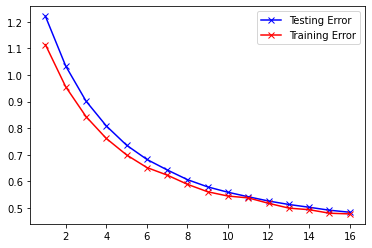

In [123]:
epochs = [int(i) for i in range(1, 17)]
plt.plot(epochs, network.history['loss'], marker = "x", color="b", label = "Testing Error")
plt.plot(epochs, network.history['val_loss'], marker = "x", color = "r", label = "Training Error")
plt.legend()